## DATA586 Project - Code

In [1]:
import numpy as np
import os
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
from sklearn import tree
import time

RANDOM_SEED = 123
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

# Our Data

In [2]:
csv = pd.read_csv("anomaly_label.csv")
csv.head(5)

,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


In [3]:
def read_file(filepath):
    fp = open(filepath)
    content = fp.readlines()
    fp.close()
    return content

log = read_file('./HDFS_sample.log')
log[1:10]

['081109 203807 222 INFO dfs.DataNode$PacketResponder: PacketResponder 0 for block blk_-6952295868487656571 terminating\n',
 '081109 204005 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864\n',
 '081109 204015 308 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_8229193803249955061 terminating\n',
 '081109 204106 329 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-6670958622368987959 terminating\n',
 '081109 204132 26 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.43.115:50010 is added to blk_3050920587428079149 size 67108864\n',
 '081109 204324 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.203.80:50010 is added to blk_7888946331804732825 size 67108864\n',
 '081109 204453 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.250.11.85:50010 is added to 

# Data Pre-processing

In [4]:
source_data = read_file('./HDFS_sample.log')
source = []
for i in range(len(source_data)):
    split_record = source_data[i][:-1].split()
    for field in split_record:
        if field[:3] == 'blk':
            record_id = field
            break
    
    data_length = len(split_record)
    # feature engineering
    # using the length of the record and the type of the record
    source.append([record_id] + [data_length] + [split_record[4]])

In [5]:
# build source dataframe
source_data = np.array(source).T
ids = source_data[0]
length = source_data[1]
record_types = source_data[2]
c = {'BlockId': ids, "BlockLength": length, "BlockType": record_types}
source_data = pd.DataFrame(c)

source_data.head(5)

,BlockId,BlockLength,BlockType
0,blk_38865049064139660,11,dfs.DataNode$PacketResponder:
1,blk_-6952295868487656571,11,dfs.DataNode$PacketResponder:
2,blk_7128370237687728475,16,dfs.FSNamesystem:
3,blk_8229193803249955061,11,dfs.DataNode$PacketResponder:
4,blk_-6670958622368987959,11,dfs.DataNode$PacketResponder:


In [6]:
# build label dataframe
data = pd.read_csv('./anomaly_label.csv')
data = data.values
for i in range(len(data)):
    if data[i][1] == 'Normal':
        data[i][1] = 1
    elif data[i][1] == 'Anomaly':
        data[i][1] = 0
data = data.T
c = {'BlockId': data[0], "BlockLable": data[1]}
label_data = pd.DataFrame(c)

label_data.head(5)

,BlockId,BlockLable
0,blk_-1608999687919862906,1
1,blk_7503483334202473044,1
2,blk_-3544583377289625738,0
3,blk_-9073992586687739851,1
4,blk_7854771516489510256,1


In [7]:
# merge the source_data and the label_data
merged_data = pd.merge(source_data, label_data)
data = merged_data.values
train_data = data[:, 1:3]
train_target = data[:, 3:]
target = []
for i in range(len(train_target)):
    target.append(int(train_target[i][0]))
train_target = target

In [8]:
type_set = []
for x in train_data:
    if x[1] not in type_set:
        type_set.append(x[1])   # get different block type

type_set

['dfs.DataNode$PacketResponder:',
 'dfs.FSNamesystem:',
 'dfs.DataNode$DataXceiver:',
 'dfs.DataBlockScanner:',
 'dfs.FSDataset:',
 'dfs.DataNode:']

In [9]:
label = LabelEncoder()
labels = label.fit_transform(type_set)  # generate random labels for type_set
label_dict = {}

for i in range(len(type_set)):
    label_dict[type_set[i]] = labels[i] # assign block type with labels
    
label_dict

{'dfs.DataNode$PacketResponder:': 2,
 'dfs.FSNamesystem:': 5,
 'dfs.DataNode$DataXceiver:': 1,
 'dfs.DataBlockScanner:': 0,
 'dfs.FSDataset:': 4,
 'dfs.DataNode:': 3}

In [10]:
for i in range(len(train_data)):
    train_data[i][1] = label_dict[train_data[i][1]]
    
for i in range(len(train_data)):
    train_data[i][0] = int(train_data[i][0])  # transfer data to int
    
train_data

array([[11, 2],
       [11, 2],
       [16, 5],
       ...,
       [12, 1],
       [11, 2],
       [12, 1]], dtype=object)

# Train/Test Set Split


- Here we use stratify to ensure that the train set and test set to have similar label distribution


In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size = 0.5, stratify = train_target)
y_train = np.array(y_train).T
y_test = np.array(y_test).T

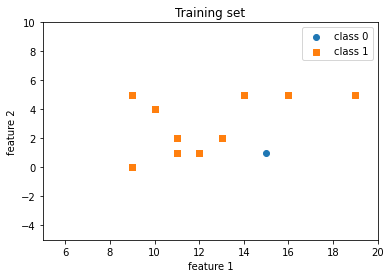

In [12]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([5, 20])
plt.ylim([-5, 10])
plt.legend()
plt.show()

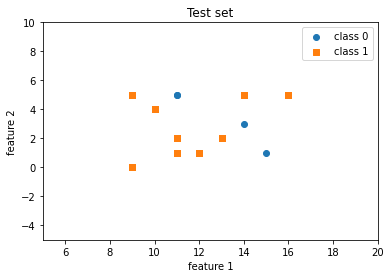

In [13]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([5, 20])
plt.ylim([-5, 10])
plt.legend()
plt.show()

# Model

In [14]:
class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=DEVICE)
        self.bias = torch.zeros(1, dtype=torch.float32, device=DEVICE)
        
        # placeholder vectors so they don't need to be recreated each time
        self.ones = torch.ones(1)
        self.zeros = torch.zeros(1)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = torch.where(linear > 0., self.ones, self.zeros)
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):     
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

# Training The Model

In [15]:
ppn = Perceptron(num_features = 2)

X_train_tensor = torch.tensor(np.array(X_train, dtype='int32'), dtype=torch.float32, device=DEVICE)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

# Evaluating The Model

In [16]:
X_test_tensor = torch.tensor(np.array(X_test, dtype='int32'), dtype=torch.float32, device=DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=DEVICE)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 96.50%


### Check out results from build-in method

In [17]:
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=30, splitter="random")
clf = clf.fit(X_train, y_train)
result = clf.score(X_test, y_test)
print('Test set accuracy: %.2f%%' % (result*100))

Test set accuracy: 96.60%


# Multilayer Perceptron with Linear Activations and ReLU Activations

In [18]:
X = train_data
y = train_target

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [19]:
class MLPLinear(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPLinear, self).__init__()
        self.num_classes = num_classes
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):     
        out = self.linear_1(x)
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [20]:
torch.manual_seed(RANDOM_SEED)

model1 = MLPLinear(num_features=2,
                   num_hidden_1=50,
                   num_classes=2)

model1 = model1.to(DEVICE)

optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

In [21]:
start_time = time.time()
minibatch_cost = []

NUM_EPOCHS = 25

features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets = torch.tensor(y, dtype=torch.long).to(DEVICE)

for epoch in range(NUM_EPOCHS):

    ### FORWARD AND BACK PROP
    logits, probas = model1(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()
    minibatch_cost.append(cost)
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

In [22]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [23]:
class MLPReLU(torch.nn.Module):

    ##Insert your code here
    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLPReLU, self).__init__()
        self.num_classes = num_classes
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):
        
        out = self.linear_1(x)
        out = F.relu(out)
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [24]:
torch.manual_seed(RANDOM_SEED)

model2 = MLPReLU( num_features = 2,
                  num_hidden_1 = 50,
                   num_classes = 2)

model2 = model2.to(DEVICE)

optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [25]:
start_time = time.time()
minibatch_cost = []

NUM_EPOCHS = 25

features = torch.tensor(X, dtype=torch.float).to(DEVICE)
targets  = torch.tensor(y, dtype=torch.long).to(DEVICE)

for epoch in range(NUM_EPOCHS):

    ### FORWARD AND BACK PROP
    #Insert your code here
    logits, probas = model2(features)
    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()
    cost.backward()
    minibatch_cost.append(cost)      
    
    
    optimizer.step()

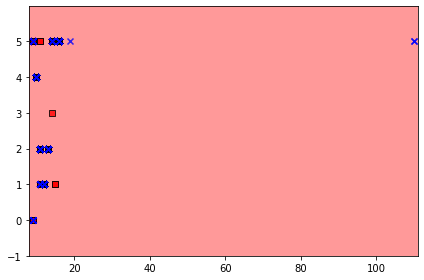

In [26]:
plot_decision_regions(features, targets, classifier=model2)

plt.tight_layout()
plt.show()